In [1]:
import os
os.add_dll_directory("C:\Program Files\\NVIDIA GPU Computing Toolkit\CUDA\\v10.1\\bin")
os.add_dll_directory("C:\Program Files\\NVIDIA GPU Computing Toolkit\CUDA\\v10.1\libnvvp")
os.add_dll_directory("C:\Program Files\\NVIDIA GPU Computing Toolkit\CUDA\\v10.1")
os.add_dll_directory("C:\Program Files\\NVIDIA GPU Computing Toolkit\CUDA\\v10.1\extras\CUPTI\lib64")
os.add_dll_directory("C:\Program Files\\NVIDIA GPU Computing Toolkit\CUDA\\v10.1\include")
os.add_dll_directory("C:\Program Files\\NVIDIA Corporation\\Nsight Compute 2019.4.0")

<AddedDllDirectory('C:\\Program Files\\NVIDIA Corporation\\Nsight Compute 2019.4.0')>

In [2]:
import numpy as np
import tensorflow as tf

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14976402022319351257,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 10520672284614380216
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 4817616896
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1604195161876448985
 physical_device_desc: "device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 15002268881865364006
 physical_device_desc: "device: XLA_GPU device"]

In [4]:
#code bellow loads the actual dataset

In [5]:
#  img_spec = tf.TensorSpec((None,128,128,3) , dtype=tf.float32)
#  feature_spec = tf.TensorSpec((1 , 39) , dtype=tf.float32)
#  dataset = tf.data.experimental.load(
#      'F:\\messy code\\afg ordered\\second generation\\tf_dataset_2',
#      element_spec = (img_spec,feature_spec),
#     compression='GZIP', 
#      reader_func=None )

In [6]:
# code bellow loads the sample dataset, that holds only images used for generating images after each epoch

In [7]:
name_spec = tf.TensorSpec((None) , dtype = tf.string)
img_spec = tf.TensorSpec((None,128,128,3) , dtype=tf.float32)
feature_spec = tf.TensorSpec((1 , 39) , dtype=tf.float32)
noise_spec = tf.TensorSpec((5,128), dtype = tf.float32)
dataset = tf.data.experimental.load(
                                    'F:\\messy code\\afg ordered\\second generation\\save_dataset',
                                    element_spec = (name_spec, img_spec,feature_spec, noise_spec),
                                    compression='GZIP', 
                                    reader_func=None )
def trainable_dataset(x,y,z,q):
    return y,z
dataset = dataset.map(lambda x,y,z,q: tf.py_function(trainable_dataset, [x,y,z,q], Tout = [tf.float32, tf.float32]))

In [8]:
next(iter(dataset))

(<tf.Tensor: shape=(1, 128, 128, 3), dtype=float32, numpy=
 array([[[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],
 
         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],
 
         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],
 
         ...,
 
         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],
 
         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],
 
         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
    

In [9]:
tensor = next(iter(dataset))
image = tensor[0]
feature = tensor[1]

image_shape = image.shape
feature_shape = feature.shape
noise_len = 128

print("image shape is : {}".format(image_shape))
print("feature shape is : {}".format(feature_shape))

image shape is : (1, 128, 128, 3)
feature shape is : (1, 39)


In [10]:
batch_size = 64 
#dataset = dataset.batch(batch_size)

In [11]:
import sys 
sys.path.insert(0, 'F:\messy code\\afg ordered\second generation')
from generator import generator_model , generator_loss
from discriminator import discriminator_model , discriminator_loss
from WGAN_GP import WGAN
def initialize_and_compile_model():
    generator_input_shape = (None , noise_len + feature_shape[1])
    wgan = WGAN(discriminator_model(),
                generator_model(input_shape = generator_input_shape),
                discriminator_steps= 3, 
                discriminator_lambda_adv = 3, 
                discriminator_lambda_cls = 5,
                discriminator_lambda_gp = 1,
                generator_lambda_adv = 1,
                generator_lambda_cls = 4,
                )
    discriminator_optimizer = tf.optimizers.Adam(learning_rate=0.00002, beta_1=0.5, name = "discriminator_optimizer")
    generator_optimizer = tf.optimizers.Adam(learning_rate=0.00002, beta_1=0.5, name = "generator_optimizer")
    wgan.compile( discriminator_optimizer , generator_optimizer , discriminator_loss , generator_loss)
    return wgan


In [12]:
wgan = initialize_and_compile_model()

final Tensor("Sigmoid_2:0", shape=(None, 128, 128, 3), dtype=float32)


In [13]:
wgan.generator.summary()

Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 167)]        0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 16384)        2752512     input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16384)        65536       dense_2[0][0]                    
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 16384)        0           batch_normalization[0][0]        
__________________________________________________________________________________________

In [14]:
wgan.discriminator.summary()

Model: "discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 63, 32)   1568        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 63, 63, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 63, 63, 32)   9248        leaky_re_lu[0][0]                
______________________________________________________________________________________

In [16]:
from callback import custom_callback
cbk = custom_callback("F:\messy code\\afg ordered\second generation\dumbster\dum", save_images= False, save_model = False)   

Epoch 1/10
33/33 [==============================] - ETA: 0s - d_loss: 8.3364 - d_loss_adv: 3.9234 - d_loss_cls: 3.6585 - d_loss_gp: 0.7545 - g_loss: 8.0881 - g_loss_cls: 0.6062 - g_loss_adv: 7.4819

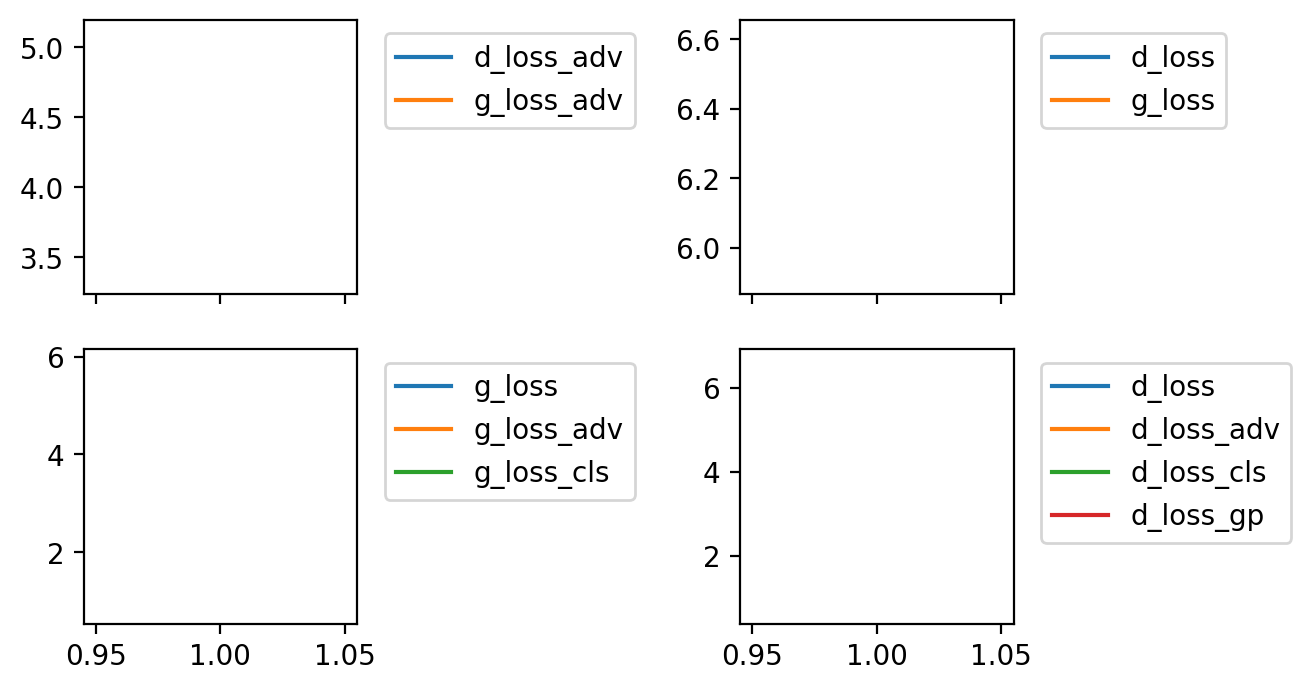

33/33 [==============================] - 6s 188ms/step - d_loss: 8.2859 - d_loss_adv: 3.9059 - d_loss_cls: 3.6275 - d_loss_gp: 0.7525 - g_loss: 8.0239 - g_loss_cls: 0.6118 - g_loss_adv: 7.4121
Epoch 2/10
33/33 [==============================] - ETA: 0s - d_loss: 6.2603 - d_loss_adv: 2.9813 - d_loss_cls: 2.5275 - d_loss_gp: 0.7514 - g_loss: 6.0235 - g_loss_cls: 0.8880 - g_loss_adv: 5.1355

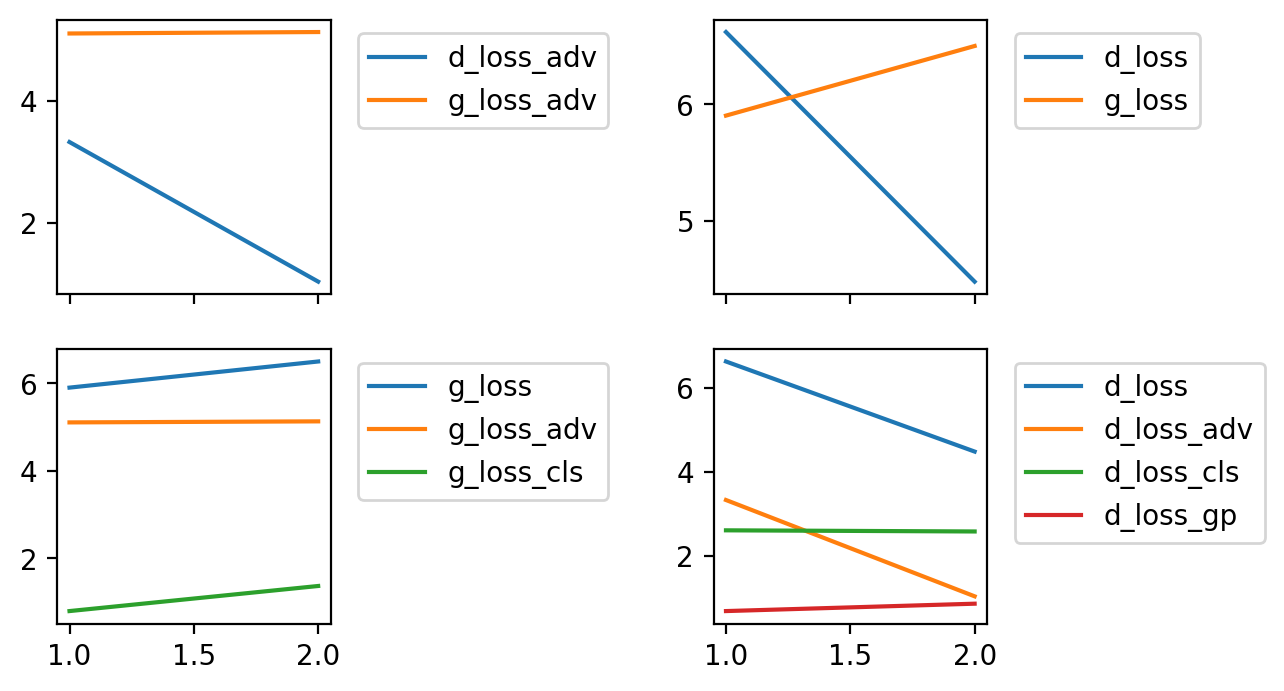

33/33 [==============================] - 6s 175ms/step - d_loss: 6.2079 - d_loss_adv: 2.9242 - d_loss_cls: 2.5290 - d_loss_gp: 0.7547 - g_loss: 6.0375 - g_loss_cls: 0.9021 - g_loss_adv: 5.1354
Epoch 3/10
33/33 [==============================] - ETA: 0s - d_loss: 5.2228 - d_loss_adv: 2.0677 - d_loss_cls: 2.5423 - d_loss_gp: 0.6128 - g_loss: 6.8398 - g_loss_cls: 1.6115 - g_loss_adv: 5.2283

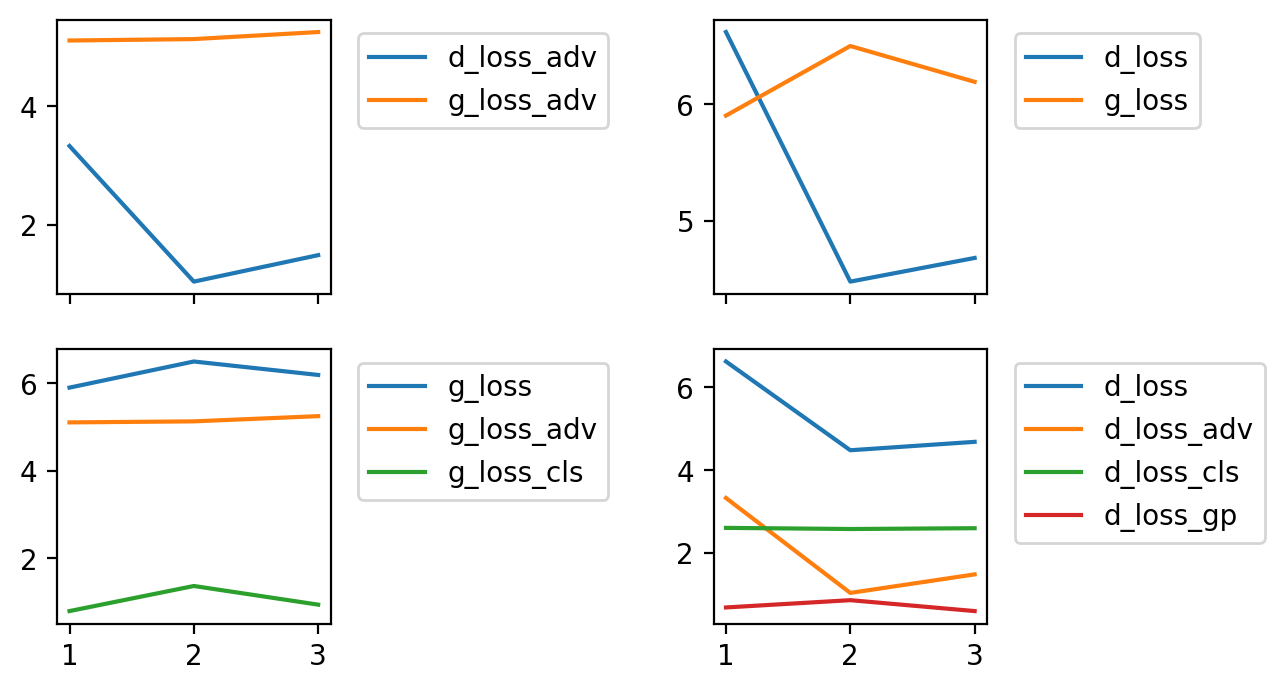

33/33 [==============================] - 5s 161ms/step - d_loss: 5.2069 - d_loss_adv: 2.0505 - d_loss_cls: 2.5440 - d_loss_gp: 0.6124 - g_loss: 6.8208 - g_loss_cls: 1.5918 - g_loss_adv: 5.2290
Epoch 4/10
33/33 [==============================] - ETA: 0s - d_loss: 4.1982 - d_loss_adv: 1.1765 - d_loss_cls: 2.5130 - d_loss_gp: 0.5087 - g_loss: 7.3825 - g_loss_cls: 2.3317 - g_loss_adv: 5.0508

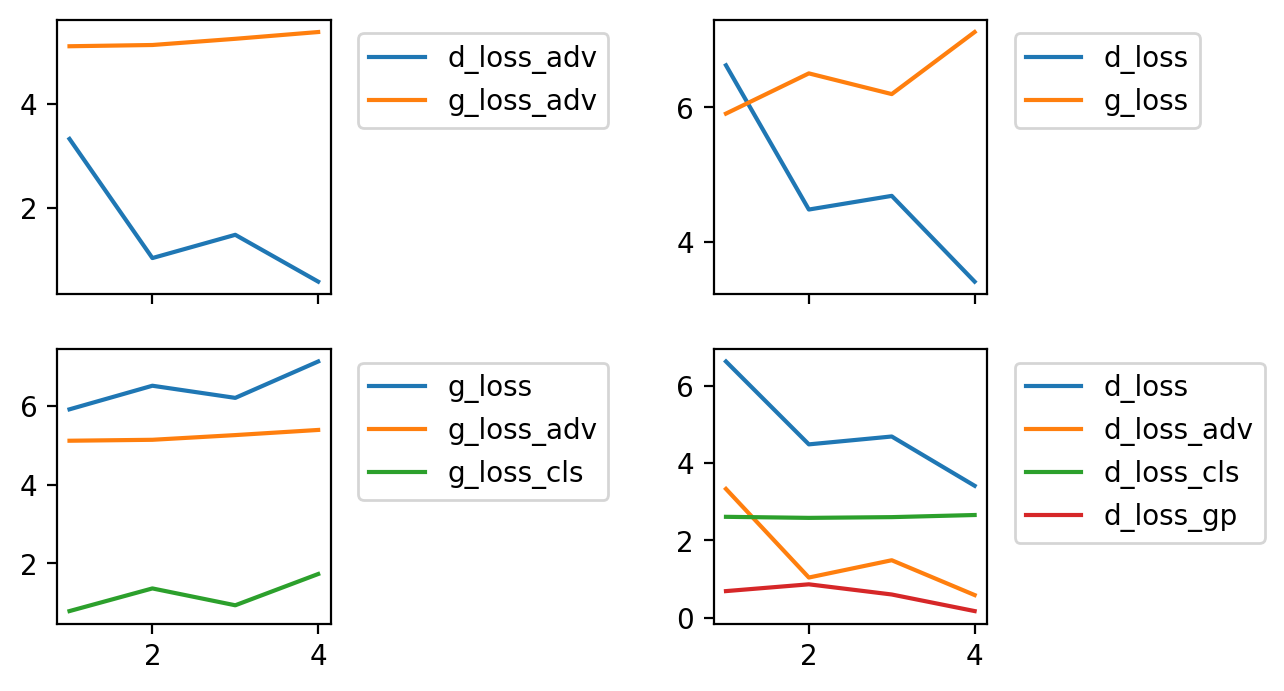

33/33 [==============================] - 5s 156ms/step - d_loss: 4.1750 - d_loss_adv: 1.1591 - d_loss_cls: 2.5172 - d_loss_gp: 0.4987 - g_loss: 7.3747 - g_loss_cls: 2.3141 - g_loss_adv: 5.0605
Epoch 5/10
33/33 [==============================] - ETA: 0s - d_loss: 3.3049 - d_loss_adv: 0.4208 - d_loss_cls: 2.4662 - d_loss_gp: 0.4178 - g_loss: 8.0452 - g_loss_cls: 3.1648 - g_loss_adv: 4.8804

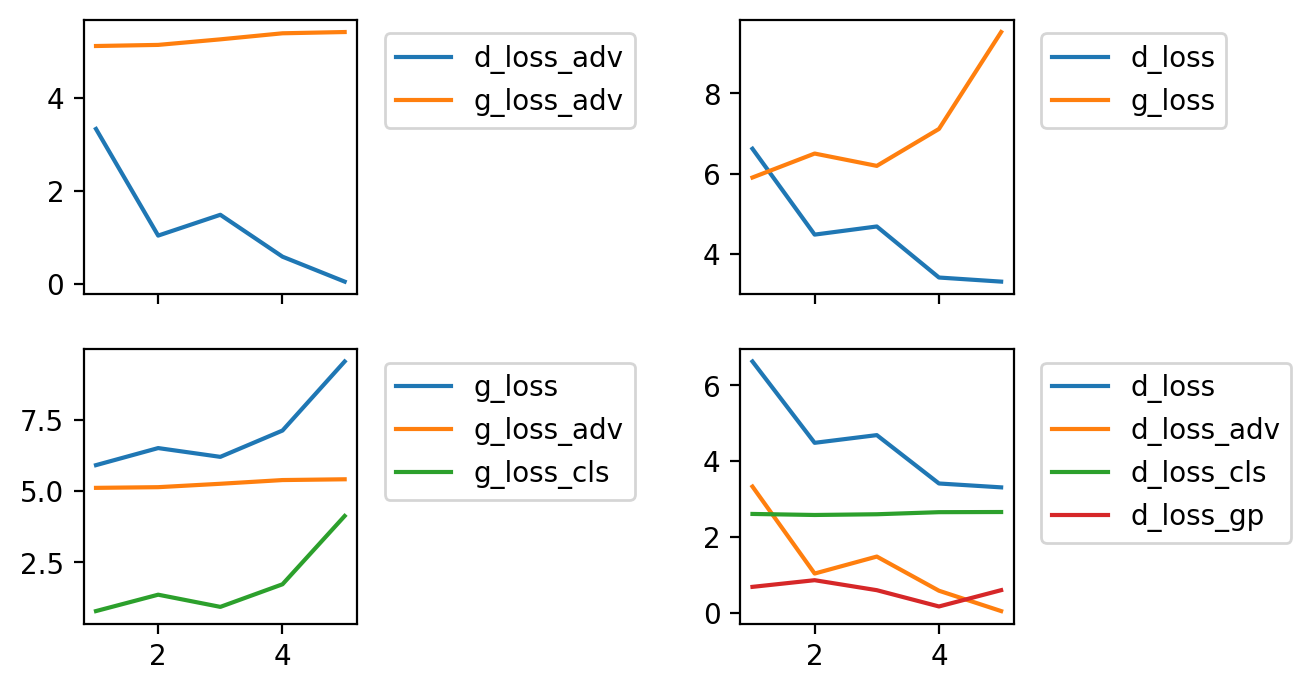

33/33 [==============================] - 5s 159ms/step - d_loss: 3.3049 - d_loss_adv: 0.4099 - d_loss_cls: 2.4718 - d_loss_gp: 0.4232 - g_loss: 8.0889 - g_loss_cls: 3.1930 - g_loss_adv: 4.8959
Epoch 6/10
33/33 [==============================] - ETA: 0s - d_loss: 3.3380 - d_loss_adv: 0.5046 - d_loss_cls: 2.4840 - d_loss_gp: 0.3494 - g_loss: 8.7543 - g_loss_cls: 3.8533 - g_loss_adv: 4.9010

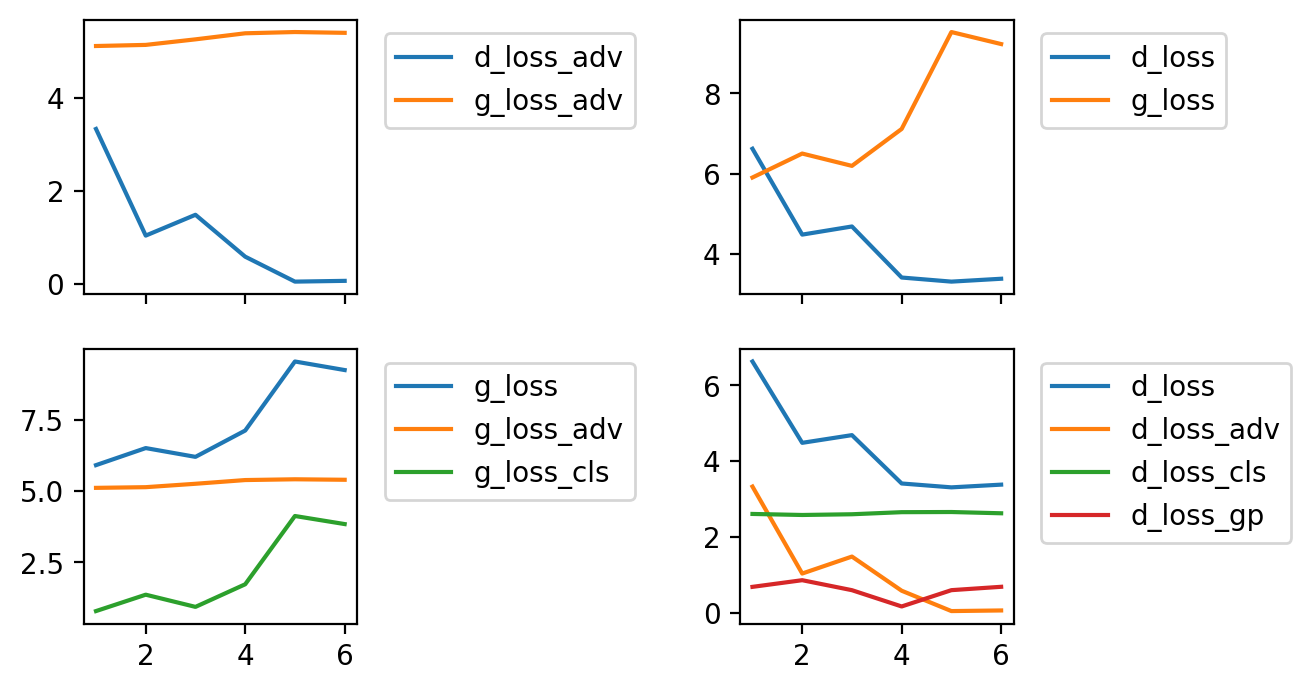

33/33 [==============================] - 5s 159ms/step - d_loss: 3.3392 - d_loss_adv: 0.4917 - d_loss_cls: 2.4881 - d_loss_gp: 0.3593 - g_loss: 8.7683 - g_loss_cls: 3.8529 - g_loss_adv: 4.9154
Epoch 7/10
33/33 [==============================] - ETA: 0s - d_loss: 2.9104 - d_loss_adv: 0.0856 - d_loss_cls: 2.4366 - d_loss_gp: 0.3881 - g_loss: 8.9298 - g_loss_cls: 4.0990 - g_loss_adv: 4.8308

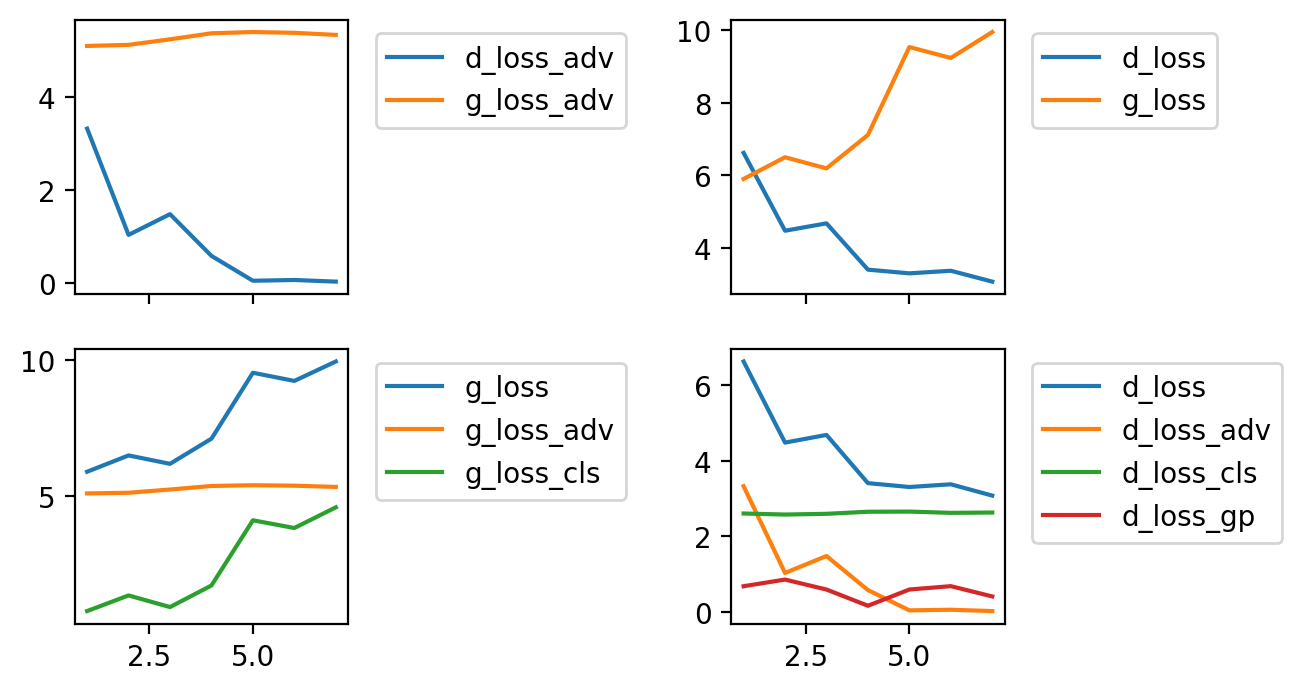

33/33 [==============================] - 5s 156ms/step - d_loss: 2.9153 - d_loss_adv: 0.0840 - d_loss_cls: 2.4424 - d_loss_gp: 0.3890 - g_loss: 8.9597 - g_loss_cls: 4.1137 - g_loss_adv: 4.8460
Epoch 8/10
33/33 [==============================] - ETA: 0s - d_loss: 3.7110 - d_loss_adv: 0.8018 - d_loss_cls: 2.4644 - d_loss_gp: 0.4448 - g_loss: 9.6891 - g_loss_cls: 4.8313 - g_loss_adv: 4.8578

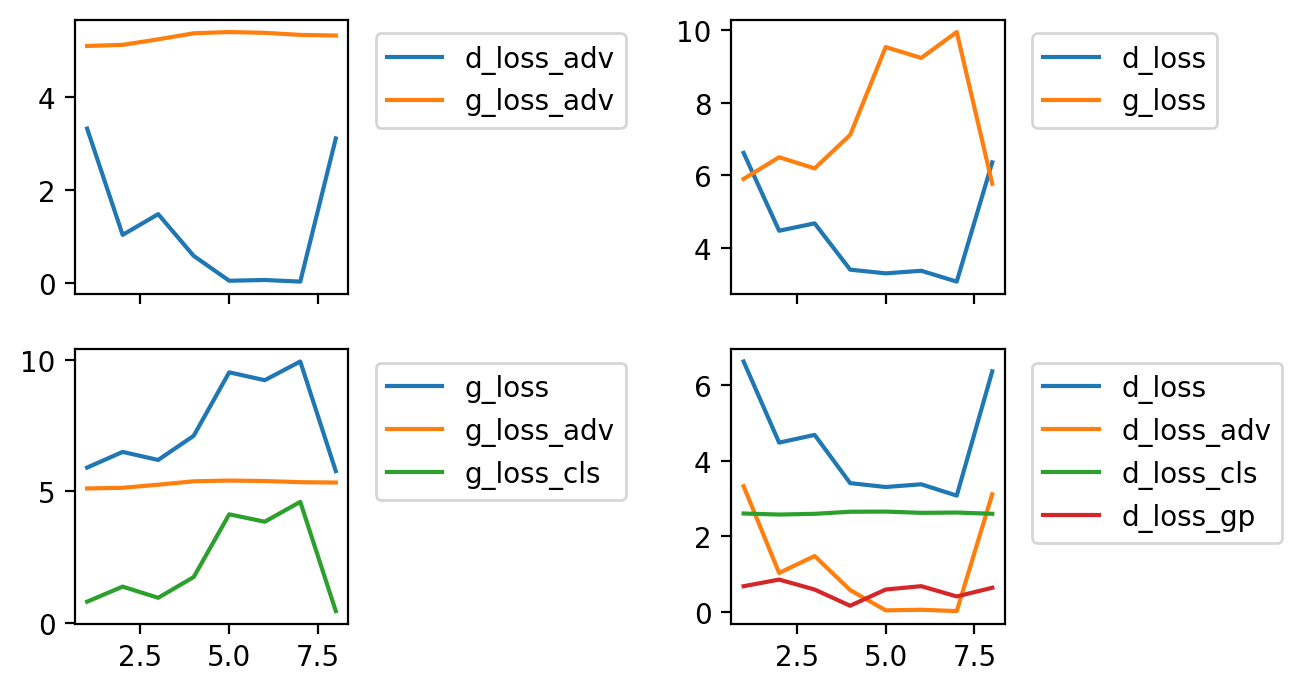

33/33 [==============================] - 5s 159ms/step - d_loss: 3.7889 - d_loss_adv: 0.8699 - d_loss_cls: 2.4684 - d_loss_gp: 0.4507 - g_loss: 9.5738 - g_loss_cls: 4.7020 - g_loss_adv: 4.8718
Epoch 9/10
33/33 [==============================] - ETA: 0s - d_loss: 3.0377 - d_loss_adv: 0.1239 - d_loss_cls: 2.4637 - d_loss_gp: 0.4500 - g_loss: 9.0310 - g_loss_cls: 4.1281 - g_loss_adv: 4.9029

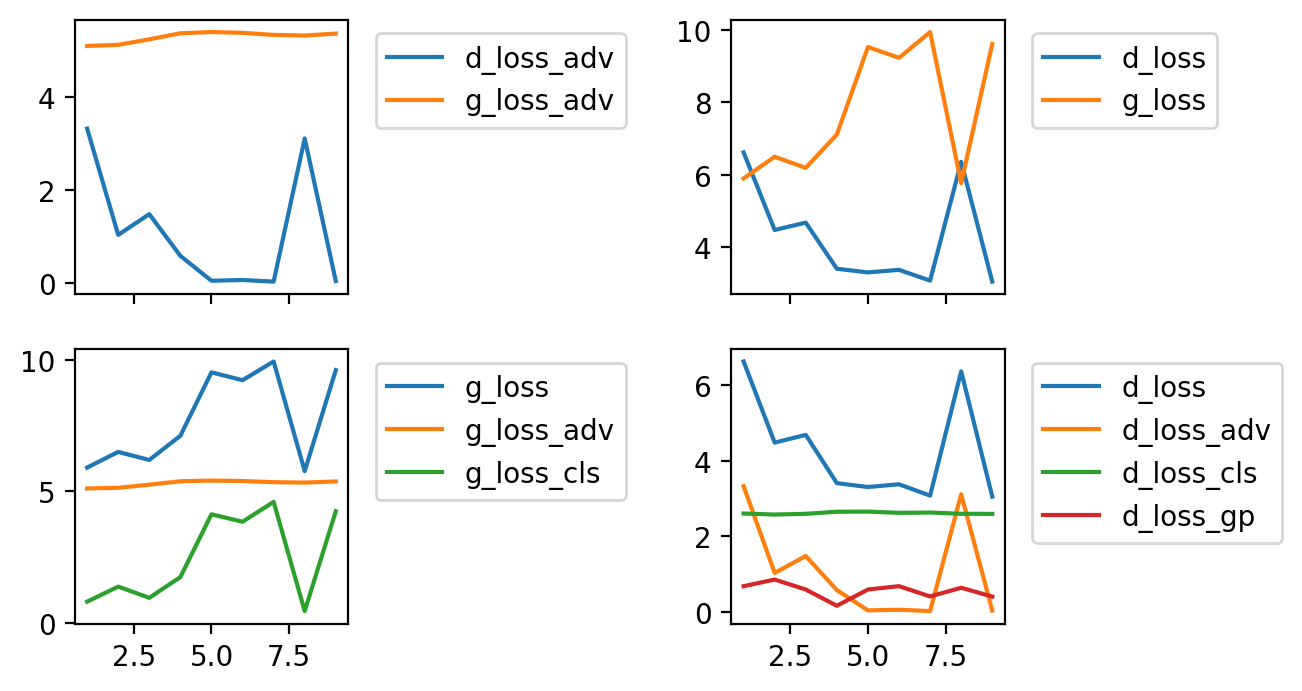

33/33 [==============================] - 6s 167ms/step - d_loss: 3.0381 - d_loss_adv: 0.1216 - d_loss_cls: 2.4676 - d_loss_gp: 0.4489 - g_loss: 9.0482 - g_loss_cls: 4.1314 - g_loss_adv: 4.9168
Epoch 10/10
33/33 [==============================] - ETA: 0s - d_loss: 2.9079 - d_loss_adv: 0.0521 - d_loss_cls: 2.4017 - d_loss_gp: 0.4542 - g_loss: 9.1242 - g_loss_cls: 4.3204 - g_loss_adv: 4.8037

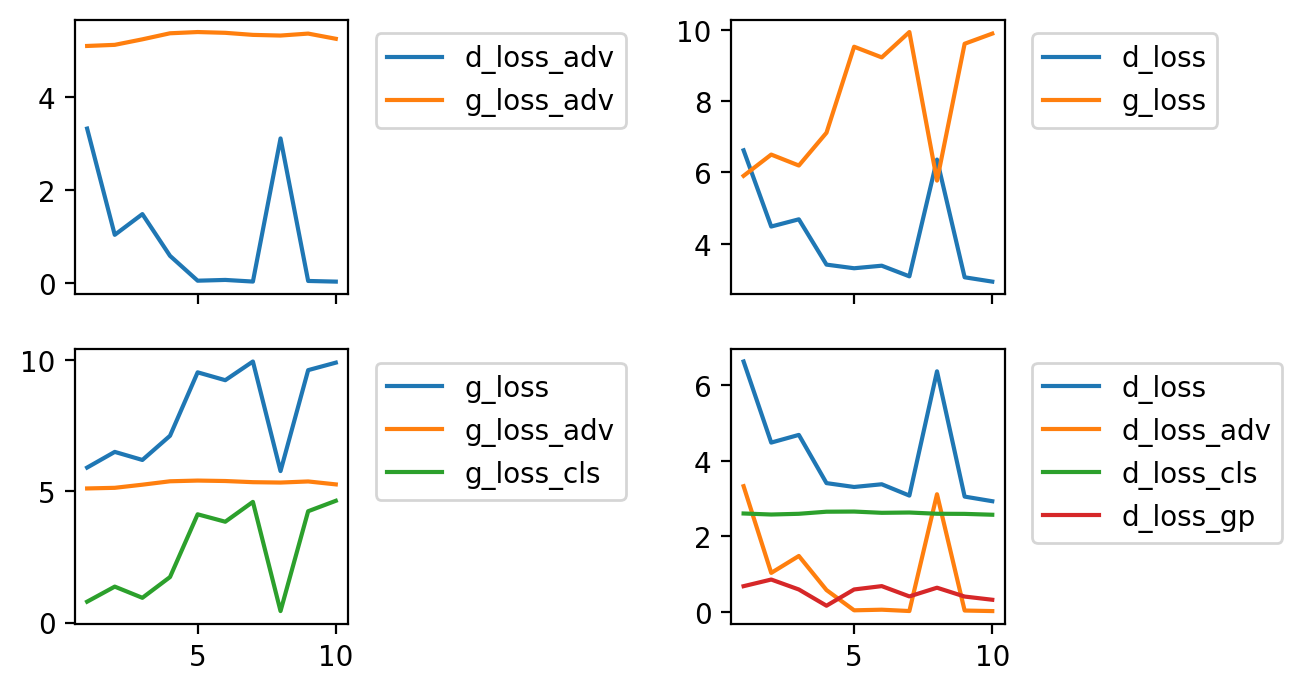

33/33 [==============================] - 6s 168ms/step - d_loss: 2.9086 - d_loss_adv: 0.0514 - d_loss_cls: 2.4068 - d_loss_gp: 0.4504 - g_loss: 9.1470 - g_loss_cls: 4.3298 - g_loss_adv: 4.8172


In [17]:
wgan.fit(dataset, epochs=10, callbacks= [cbk])
